<a href="https://colab.research.google.com/github/mansamoussa/llm-skill-extractor/blob/main/notebooks/04_skill_extraction_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Stage Job Advertisement Analysis — LLM Skill Extractor

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mansamoussa/llm-skill-extractor/blob/main/notebooks/04_skill_extraction_llm.ipynb)

---

### Objective
Extract professional skills from job advertisements using a Large Language Model (OpenAI GPT) after identifying the relevant "Skills and Content" zones with our fine-tuned BERT model.

This notebook will:
1. Load the fine-tuned BERT model from Task 2 (zone identification)
2. Load job advertisement data (both annotated and scraped datasets)
3. Use BERT to identify "Fähigkeiten und Inhalte" (Skills and Content) zones
4. Extract those text sections containing skills
5. Use OpenAI GPT API to intelligently extract individual professional skills
6. Structure and save the extracted skills in JSON format
7. Evaluate the quality and coverage of skill extraction

### Why This Task is Important
The BERT model from Tasks 1-3 can identify WHERE skills are mentioned in a job ad, but it cannot extract the SPECIFIC skills themselves. This is a perfect task for a Large Language Model (LLM) because:
- LLMs understand context and can identify implicit skills
- They can handle multilingual text (German, French, English)
- They can normalize skill names (e.g., "JS" → "JavaScript")
- They can distinguish between skills and other job requirements

### Input Data
- `model/best_model.pt` — fine-tuned BERT model from Task 2
- `model/id2label.json` and `model/label2id.json` — label mappings
- `data/annotated.json` — annotated job advertisements (German/French)
- `data/scraped/remoteok_jobs.jsonl` — scraped job postings (English)

### Output
- `data/extracted_skills.json` — structured skill extraction results
- `data/skill_statistics.json` — statistics and analysis
- Evaluation metrics and visualizations


---
# 1. Setting up my Environment

**Objective:** Prepare the Google Colab environment by cloning the project repository and installing necessary dependencies.

**Why I need this:**
* **The Issue:** A fresh Colab session is empty and doesn't have my project files or the required libraries.
* **The Fix:** I clone my repository to get the code, and install dependencies including OpenAI API library.

**What I did:**
1. **Clone Repository:** Downloaded project files from GitHub
2. **Install Dependencies:** Installed Python libraries including `openai`, `torch`, `transformers`

In [1]:
# --- SETUP STEPS ---
# This cell prepares the Colab environment by downloading the code and installing libraries.
import os

# 1. Clone the repository if it doesn't exist in the notebook
if not os.path.exists('llm-skill-extractor'):
    !git clone https://github.com/mansamoussa/llm-skill-extractor.git
else:
    print("Repository already cloned.")

# 2. Install core dependencies (including both OpenAI and Google Gemini)
!pip install -q torch transformers openai google-generativeai pandas tqdm scikit-learn matplotlib seaborn

print("✅ Environment setup complete!")

Cloning into 'llm-skill-extractor'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 142 (delta 74), reused 31 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 3.20 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (74/74), done.
✅ Environment setup complete!


# 2. Loading my Data

**Objective:** Load both the annotated dataset and scraped job postings from Google Drive.

**Why I need this:**
* **The Issue:** The annotated data is private and not in the GitHub repo.
* **The Fix:** I mount Google Drive and copy the necessary data files to the project folder.

**What I did:**
1. **Mount Drive:** Connected to Google Drive
2. **Copy Files:** Copied `annotated.json` to the data folder

In [2]:
# --- DATA LOADING STEP ---
# This cell brings the data from Google Drive into the project environment
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths (adjust if your Drive structure is different)
source_path = '/content/drive/MyDrive/GEN03/annotated.json'
destination_folder = '/content/llm-skill-extractor/data/'

# 3. Copy the annotated data file
if os.path.exists(source_path):
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(source_path, destination_folder)
    print(f"✅ Success! annotated.json copied to {destination_folder}")
else:
    print(f"⚠️ File not found at {source_path}")
    print("Please verify the path or upload 'annotated.json' manually to 'llm-skill-extractor/data/' folder.")

print("\n📊 Checking data files...")
data_files = ['annotated.json', 'scraped/remoteok_jobs.jsonl']
for file in data_files:
    full_path = os.path.join(destination_folder, file)
    if os.path.exists(full_path):
        size_mb = os.path.getsize(full_path) / (1024 * 1024)
        print(f"✅ Found: {file} ({size_mb:.2f} MB)")
    else:
        print(f"❌ Missing: {file}")

Mounted at /content/drive
✅ Success! annotated.json copied to /content/llm-skill-extractor/data/

📊 Checking data files...
✅ Found: annotated.json (13.93 MB)
✅ Found: scraped/remoteok_jobs.jsonl (0.31 MB)


# 3. Loading the Trained BERT Model

**Objective:** Load the fine-tuned BERT model and label mappings from Task 2 (or from Google Drive backup).

**Why I need this:**
* **The Issue:** I need the trained model to identify which parts of the job ads contain skills.
* **The Fix:** Load the model weights, tokenizer, and label mappings from the previous training task.

**What I did:**
1. **Check Local Files:** Look for model files in the project folder
2. **Load from Drive:** If not found locally, copy from Google Drive backup
3. **Initialize Model:** Load BERT model with trained weights
4. **Load Mappings:** Load the label2id and id2label dictionaries

In [3]:
# Check if model files exist and copy from Drive if needed
import os
import shutil

MODEL_DIR = '/content/llm-skill-extractor/model'
drive_model_path = '/content/drive/MyDrive/GEN03/model'

print("🔍 Checking for model files...")
print(f"Looking in Drive: {drive_model_path}")

if os.path.exists(drive_model_path):
    print(f"✅ Found model folder in Drive")

    # List files in Drive model folder
    print("\n📂 Files in Drive model folder:")
    for file in os.listdir(drive_model_path):
        file_path = os.path.join(drive_model_path, file)
        if os.path.isfile(file_path):
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"   - {file} ({size_mb:.2f} MB)")

    # Copy to local project folder
    print(f"\n📥 Copying model files to {MODEL_DIR}...")
    os.makedirs(MODEL_DIR, exist_ok=True)
    shutil.copytree(drive_model_path, MODEL_DIR, dirs_exist_ok=True)
    print("✅ Model files copied successfully!")

    # Verify
    print("\n✅ Verification - Files now in project:")
    for file in ['best_model.pt', 'id2label.json', 'label2id.json']:
        path = os.path.join(MODEL_DIR, file)
        if os.path.exists(path):
            print(f"   ✅ {file}")
        else:
            print(f"   ❌ {file} - MISSING!")
else:
    print(f"❌ Model folder not found at {drive_model_path}")
    print("\n💡 Please check:")
    print("   1. Did you run Cell 2 to mount Google Drive?")
    print("   2. Do you have the model files from Task 2?")
    print("   3. Are they saved in MyDrive/GEN03/model/ ?")
    print("\n📍 Try browsing your Drive manually to find the model files")

🔍 Checking for model files...
Looking in Drive: /content/drive/MyDrive/GEN03/model
✅ Found model folder in Drive

📂 Files in Drive model folder:
   - best_model.pt (676.31 MB)
   - id2label.json (0.00 MB)
   - label2id.json (0.00 MB)

📥 Copying model files to /content/llm-skill-extractor/model...
✅ Model files copied successfully!

✅ Verification - Files now in project:
   ✅ best_model.pt
   ✅ id2label.json
   ✅ label2id.json


In [ ]:
# --- MODEL LOADING STEP ---
# Load the trained BERT model for zone identification
import torch
import json
from transformers import BertTokenizerFast, BertForTokenClassification

# Define paths
PROJECT_ROOT = '/content/llm-skill-extractor'
MODEL_DIR = os.path.join(PROJECT_ROOT, 'model')
BEST_MODEL_PATH = os.path.join(MODEL_DIR, 'best_model.pt')
ID2LABEL_PATH = os.path.join(MODEL_DIR, 'id2label.json')
LABEL2ID_PATH = os.path.join(MODEL_DIR, 'label2id.json')

# Check if model files exist locally, if not try to load from Drive
drive_model_path = '/content/drive/MyDrive/GEN03/model'
if not os.path.exists(BEST_MODEL_PATH) and os.path.exists(drive_model_path):
    print("📥 Model not found locally, copying from Google Drive...")
    shutil.copytree(drive_model_path, MODEL_DIR, dirs_exist_ok=True)
    print("✅ Model files copied from Drive")

# Load label mappings
print("📖 Loading label mappings...")
with open(ID2LABEL_PATH, 'r') as f:
    id2label = json.load(f)
    # Convert keys to integers
    id2label = {int(k): v for k, v in id2label.items()}

with open(LABEL2ID_PATH, 'r') as f:
    label2id = json.load(f)

print(f"✅ Found {len(label2id)} labels: {list(label2id.keys())}")

# Initialize tokenizer
print("🔤 Loading tokenizer...")
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

# Initialize and load the model
print("🤖 Loading BERT model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_labels = len(label2id)
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Load trained weights
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

print("✅ BERT model loaded successfully!")
print(f"   Model has {num_labels} output labels")
print(f"   Target label for skill extraction: 'Fähigkeiten und Inhalte'")

# 4. Configuring LLM APIs (OpenAI & Gemini)

**Objective:** Set up both OpenAI and Google Gemini API connections for skill extraction.

**Why I need this:**
* **The Issue:** I need to authenticate with LLM providers to use their models for intelligent skill extraction.
* **The Fix:** Configure both API keys and allow choosing which model to use.

**Why Both APIs?**
* **Flexibility:** Choose the best model for your needs
* **Comparison:** Test which LLM performs better for skill extraction  
* **Cost:** Gemini is free, OpenAI costs money but might be more accurate

**Security Note:** In production, never hardcode API keys. Use environment variables or secret management systems.

**What I did:**
1. **Set API Keys:** Configure both OpenAI and Gemini authentication
2. **Test Connections:** Verify both APIs are accessible
3. **Choose Default:** Select which LLM to use (can be changed later)

In [12]:
# --- LLM SETUP (OPENAI & GEMINI) ---
# Configure both OpenAI and Google Gemini APIs for skill extraction
from openai import OpenAI
import google.generativeai as genai
import os

# Set your API keys
# IMPORTANT: Replace with your own API keys before running
# Option 1: Hardcode them here (not recommended for public repos)
# Option 2: Use Google Colab secrets (recommended)
OPENAI_API_KEY = "OPENAI_KEY"  # Replace with your OpenAI API key
GEMINI_API_KEY = "GEMINI_KEY"   # Replace with your Gemini API key

# Initialize OpenAI client
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# Initialize Gemini
genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel('gemini-2.5-flash')

# Test OpenAI connection
print("🔗 Testing OpenAI API connection...")
try:
    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Say 'OpenAI API test successful' in 5 words or less."}
        ],
        max_tokens=20
    )
    print(f"✅ OpenAI API Connection successful!")
    print(f"   Response: {response.choices[0].message.content}")
except Exception as e:
    print(f"❌ OpenAI API Connection failed: {e}")
    openai_client = None

# Test Gemini connection
print("\n🔗 Testing Gemini API connection...")
try:
    response = gemini_model.generate_content("Say 'Gemini API test successful' in 5 words or less.")
    print(f"✅ Gemini API Connection successful!")
    print(f"   Response: {response.text.strip()}")
except Exception as e:
    print(f"❌ Gemini API Connection failed: {e}")
    gemini_model = None

# Choose which LLM to use (you can change this later)
# Options: "openai" or "gemini"
USE_LLM = "openai"  # Default to Gemini (free tier)

print(f"\n🎯 Selected LLM: {USE_LLM.upper()}")
if USE_LLM == "openai" and openai_client is None:
    print("⚠️ OpenAI selected but connection failed. Falling back to Gemini.")
    USE_LLM = "gemini"
elif USE_LLM == "gemini" and gemini_model is None:
    print("⚠️ Gemini selected but connection failed. Falling back to OpenAI.")
    USE_LLM = "openai"

🔗 Testing OpenAI API connection...
✅ OpenAI API Connection successful!
   Response: OpenAI API test successful.

🔗 Testing Gemini API connection...


❌ Gemini API Connection failed: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash
Please retry in 38.865961465s.

🎯 Selected LLM: OPENAI


# 5. Helper Function: Extract Skills Section Using BERT

**Objective:** Create a function that uses the trained BERT model to identify and extract the "Fähigkeiten und Inhalte" (Skills and Content) sections from job advertisements.

**Why I need this:**
* **The Issue:** Job ads contain many sections (company info, benefits, application process, etc.). I only want the parts that list skills.
* **The Fix:** Use BERT to classify each token, then extract continuous spans labeled as "Fähigkeiten und Inhalte".

**How it works:**
1. Tokenize the job ad text
2. Run BERT to predict labels for each token
3. Find all tokens labeled as "Fähigkeiten und Inhalte"
4. Reconstruct the original text from those tokens
5. Return the extracted skill sections

**What I did:**
Created a reusable function that processes any job advertisement text and returns only the skills sections.

In [6]:
# --- BERT EXTRACTION FUNCTION ---
# Function to extract skills sections using the trained BERT model

def extract_skills_section_with_bert(text, model, tokenizer, device, target_label="Fähigkeiten und Inhalte"):
    """
    Extract sections labeled as target_label from the input text using BERT.

    Args:
        text (str): Input job advertisement text
        model: Trained BERT model for token classification
        tokenizer: BERT tokenizer
        device: torch device (cuda or cpu)
        target_label (str): The label to extract (default: "Fähigkeiten und Inhalte")

    Returns:
        list: List of extracted text sections labeled as target_label
    """
    if not text or len(text.strip()) == 0:
        return []

    # Tokenize with offset mapping to track character positions
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding=False,
        return_offsets_mapping=True
    )

    offset_mapping = encoding.pop('offset_mapping')[0]
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)[0]

    # Convert predictions to labels
    predicted_labels = [id2label[pred.item()] for pred in predictions]

    # Extract skill sections
    skill_sections = []
    current_section = []
    current_start = None

    for idx, (label, (start, end)) in enumerate(zip(predicted_labels, offset_mapping)):
        # Skip special tokens ([CLS], [SEP], [PAD])
        if start == end == 0:
            continue

        if label == target_label:
            if current_start is None:
                current_start = start.item()
            current_section.append((start.item(), end.item()))
        else:
            # End of a skill section
            if current_section:
                # Extract the text for this section
                section_start = current_section[0][0]
                section_end = current_section[-1][1]
                section_text = text[section_start:section_end].strip()
                if section_text:
                    skill_sections.append(section_text)
                current_section = []
                current_start = None

    # Don't forget the last section if it ends at the document end
    if current_section:
        section_start = current_section[0][0]
        section_end = current_section[-1][1]
        section_text = text[section_start:section_end].strip()
        if section_text:
            skill_sections.append(section_text)

    return skill_sections

print("✅ BERT extraction function defined!")
print("   Function: extract_skills_section_with_bert()")

✅ BERT extraction function defined!
   Function: extract_skills_section_with_bert()


# 6. Helper Function: Extract Skills Using LLM

**Objective:** Create a function that uses OpenAI GPT to extract individual skills from the text sections identified by BERT.

**Why I need this:**
* **The Issue:** The BERT model tells me WHERE skills are mentioned, but not WHAT the specific skills are.
* **The Fix:** Use an LLM with a carefully crafted prompt to intelligently extract and normalize skill names.

**How it works:**
1. Take a text section containing skills
2. Send it to GPT with a specialized prompt
3. GPT identifies individual skills (technical skills, soft skills, languages, tools)
4. Return structured JSON with categorized skills

**Prompt Engineering:**
The prompt instructs GPT to:
- Extract only professional skills (not job titles or company names)
- Normalize skill names (e.g., "JS" → "JavaScript")
- Categorize skills (technical, soft, languages, tools, certifications)
- Return results in a structured JSON format
- Handle multilingual text (German, French, English)

**What I did:**
Created a reusable function with a well-engineered prompt for consistent skill extraction.

In [11]:
# --- LLM EXTRACTION FUNCTIONS ---
# Functions to extract individual skills using OpenAI GPT or Google Gemini

import json
import re

def extract_skills_with_openai(text_section, client, model_name="gpt-4o-mini"):
    """Extract skills using OpenAI GPT."""
    if not text_section or len(text_section.strip()) == 0:
        return get_empty_skills_dict()

    system_prompt = get_skill_extraction_prompt()
    user_prompt = f"""Extract and categorize all professional skills from this job advertisement text:

TEXT:
{text_section}

Return only the JSON object with categorized skills."""

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.3,
            max_tokens=1000,
            response_format={"type": "json_object"}
        )

        skills_data = json.loads(response.choices[0].message.content)
        return ensure_all_skill_keys(skills_data)

    except Exception as e:
        print(f"⚠️ OpenAI extraction error: {e}")
        return get_empty_skills_dict(error=str(e))

def extract_skills_with_gemini(text_section, model):
    """Extract skills using Google Gemini."""
    if not text_section or len(text_section.strip()) == 0:
        return get_empty_skills_dict()

    system_prompt = get_skill_extraction_prompt()
    full_prompt = f"""{system_prompt}

Extract and categorize all professional skills from this job advertisement text:

TEXT:
{text_section}

Return ONLY the JSON object with categorized skills, no other text."""

    try:
        response = model.generate_content(
            full_prompt,
            generation_config=genai.GenerationConfig(
                temperature=0.3,
                max_output_tokens=1000,
            )
        )

        # Extract JSON from response (Gemini might add markdown code blocks)
        response_text = response.text.strip()

        # Remove markdown code blocks if present
        json_match = re.search(r'```(?:json)?\s*({.*?})\s*```', response_text, re.DOTALL)
        if json_match:
            json_str = json_match.group(1)
        else:
            # Try to find JSON object directly
            json_match = re.search(r'{.*}', response_text, re.DOTALL)
            json_str = json_match.group(0) if json_match else response_text

        skills_data = json.loads(json_str)
        return ensure_all_skill_keys(skills_data)

    except Exception as e:
        print(f"⚠️ Gemini extraction error: {e}")
        return get_empty_skills_dict(error=str(e))

def extract_skills_with_llm(text_section, use_llm="gemini"):
    """
    Unified function to extract skills using either OpenAI or Gemini.

    Args:
        text_section (str): Text containing skill descriptions
        use_llm (str): Which LLM to use - "openai" or "gemini"

    Returns:
        dict: Structured skills data with categories
    """
    if use_llm == "openai" and openai_client:
        return extract_skills_with_openai(text_section, openai_client)
    elif use_llm == "gemini" and gemini_model:
        return extract_skills_with_gemini(text_section, gemini_model)
    else:
        print(f"⚠️ Selected LLM '{use_llm}' not available")
        return get_empty_skills_dict(error=f"LLM {use_llm} not available")

# Helper functions
def get_empty_skills_dict(error=None):
    """Return an empty skills dictionary."""
    result = {
        "technical_skills": [],
        "soft_skills": [],
        "languages": [],
        "tools": [],
        "certifications": [],
        "other_skills": []
    }
    if error:
        result["error"] = error
    return result

def ensure_all_skill_keys(skills_data):
    """Ensure all expected keys exist in the skills dictionary."""
    expected_keys = ["technical_skills", "soft_skills", "languages", "tools", "certifications", "other_skills"]
    for key in expected_keys:
        if key not in skills_data:
            skills_data[key] = []
    return skills_data

def get_skill_extraction_prompt():
    """Get the standard prompt for skill extraction."""
    return """You are an expert HR analyst specializing in extracting professional skills from job advertisements.
Your task is to extract and categorize skills mentioned in the provided text.

RULES:
1. Extract only genuine professional skills, tools, technologies, and qualifications
2. Do NOT extract:
   - Job titles or positions
   - Company names
   - General job responsibilities
   - Benefits or salary information
3. Normalize skill names (e.g., "JS" → "JavaScript", "ML" → "Machine Learning")
4. Handle multilingual text (German, French, English)
5. Categorize skills appropriately

Return ONLY a JSON object with this exact structure (no additional text):
{
  "technical_skills": ["skill1", "skill2"],
  "soft_skills": ["skill1", "skill2"],
  "languages": ["language1", "language2"],
  "tools": ["tool1", "tool2"],
  "certifications": ["cert1", "cert2"],
  "other_skills": ["skill1", "skill2"]
}"""

print("✅ LLM extraction functions defined!")
print(f"   Functions: extract_skills_with_llm() [supports both OpenAI and Gemini]")
print(f"   Currently using: {USE_LLM.upper()}")

✅ LLM extraction functions defined!
   Functions: extract_skills_with_llm() [supports both OpenAI and Gemini]
   Currently using: GEMINI


# 7. Load and Prepare Job Advertisement Data

**Objective:** Load both the annotated dataset and scraped job postings, preparing them for skill extraction.

**Why I need this:**
* **The Issue:** I have two different data sources with different formats.
* **The Fix:** Load both datasets and standardize them into a common format.

**What I did:**
1. Load annotated.json (German/French job ads)
2. Load scraped remoteok_jobs.jsonl (English job ads)
3. Create a unified data structure
4. Display sample data for verification

In [8]:
# --- DATA LOADING ---
# Load and prepare job advertisement data
import pandas as pd
import json

DATA_PATH = os.path.join(PROJECT_ROOT, 'data')

# 1. Load annotated data (German/French)
print("📖 Loading annotated job advertisements...")
annotated_path = os.path.join(DATA_PATH, 'annotated.json')
df_annotated = pd.read_json(annotated_path)

# Extract the text content from the data field
df_annotated['text'] = df_annotated['data'].apply(lambda x: x.get('content_clean', '') if isinstance(x, dict) else '')
df_annotated['source'] = 'annotated'
df_annotated['language'] = 'de/fr'  # German/French

print(f"✅ Loaded {len(df_annotated)} annotated job ads")

# 2. Load scraped data (English)
print("📖 Loading scraped job advertisements...")
scraped_path = os.path.join(DATA_PATH, 'scraped', 'remoteok_jobs.jsonl')

scraped_jobs = []
with open(scraped_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            scraped_jobs.append(json.loads(line))

df_scraped = pd.DataFrame(scraped_jobs)
df_scraped['text'] = df_scraped['description']
df_scraped['source'] = 'scraped'
df_scraped['language'] = 'en'

print(f"✅ Loaded {len(df_scraped)} scraped job ads")

# 3. Create unified dataset
print("\n🔄 Creating unified dataset...")
jobs_data = []

# Add annotated jobs
for idx, row in df_annotated.iterrows():
    jobs_data.append({
        'id': f"annotated_{idx}",
        'text': row['text'],
        'source': row['source'],
        'language': row['language'],
        'title': '',  # Not available in annotated data
        'company': ''  # Not available in annotated data
    })

# Add scraped jobs
for idx, row in df_scraped.iterrows():
    jobs_data.append({
        'id': f"scraped_{idx}",
        'text': row['text'],
        'source': row['source'],
        'language': row['language'],
        'title': row.get('title', ''),
        'company': row.get('company', '')
    })

print(f"✅ Total dataset: {len(jobs_data)} job advertisements")
print(f"   - Annotated (de/fr): {len(df_annotated)}")
print(f"   - Scraped (en): {len(df_scraped)}")

# Display sample
print("\n📊 Sample job advertisement:")
sample = jobs_data[0]
print(f"ID: {sample['id']}")
print(f"Source: {sample['source']}")
print(f"Language: {sample['language']}")
print(f"Text preview: {sample['text'][:200]}...")

📖 Loading annotated job advertisements...
✅ Loaded 2699 annotated job ads
📖 Loading scraped job advertisements...
✅ Loaded 85 scraped job ads

🔄 Creating unified dataset...
✅ Total dataset: 2784 job advertisements
   - Annotated (de/fr): 2699
   - Scraped (en): 85

📊 Sample job advertisement:
ID: annotated_0
Source: annotated
Language: de/fr
Text preview: MISSION Effectuer les contrôles techniques conformément à la loi fédérale sur la circulation routière et à ses dispositions d'exécution ainsi qu'aux directives nationales et européennes applicables en...


# 8. Test Extraction Pipeline on Sample

**Objective:** Test the complete extraction pipeline (BERT + LLM) on a sample job advertisement before processing the full dataset.

**Why I need this:**
* **The Issue:** Processing all job ads with the API costs money and time. I need to verify the pipeline works correctly first.
* **The Fix:** Run the pipeline on a few sample ads and inspect the results.

**What I did:**
1. Select a sample job advertisement
2. Extract skills sections using BERT
3. Extract individual skills using LLM
4. Display and verify the results

In [13]:
# --- PIPELINE TEST ---
# Test the extraction pipeline on sample data

print("🧪 Testing extraction pipeline on sample job advertisement...\n")

# Select a sample from scraped data (usually has clearer skill descriptions)
test_sample = [job for job in jobs_data if job['source'] == 'scraped'][0]

print(f"📄 Sample Job: {test_sample['title']}")
print(f"   Company: {test_sample['company']}")
print(f"   Source: {test_sample['source']}")
print(f"   Text length: {len(test_sample['text'])} characters")
print("\n" + "="*80)

# Step 1: Extract skills sections using BERT
print("\n🤖 Step 1: Extracting skills sections with BERT...")
skill_sections = extract_skills_section_with_bert(
    test_sample['text'],
    model,
    tokenizer,
    device
)

print(f"✅ Found {len(skill_sections)} skills section(s)")
for i, section in enumerate(skill_sections, 1):
    print(f"\n   Section {i} ({len(section)} chars):")
    print(f"   {section[:200]}..." if len(section) > 200 else f"   {section}")

# Step 2: Extract individual skills using LLM
print("\n🧠 Step 2: Extracting individual skills with LLM...")
all_extracted_skills = {
    "technical_skills": [],
    "soft_skills": [],
    "languages": [],
    "tools": [],
    "certifications": [],
    "other_skills": []
}

for i, section in enumerate(skill_sections, 1):
    print(f"\n   Processing section {i}...")
    skills = extract_skills_with_llm(section, use_llm=USE_LLM)

    # Merge results
    for key in all_extracted_skills.keys():
        if key in skills:
            all_extracted_skills[key].extend(skills[key])

# Remove duplicates
for key in all_extracted_skills.keys():
    all_extracted_skills[key] = list(set(all_extracted_skills[key]))

# Display results
print("\n" + "="*80)
print("📊 EXTRACTION RESULTS:")
print("="*80)

for category, skills in all_extracted_skills.items():
    if skills:
        print(f"\n{category.upper().replace('_', ' ')}:")
        for skill in sorted(skills):
            print(f"  • {skill}")

total_skills = sum(len(v) for v in all_extracted_skills.values())
print(f"\n✅ Total unique skills extracted: {total_skills}")

🧪 Testing extraction pipeline on sample job advertisement...

📄 Sample Job: Software Engineer
   Company: Jump
   Source: scraped
   Text length: 3217 characters


🤖 Step 1: Extracting skills sections with BERT...
✅ Found 16 skills section(s)

   Section 1 (3 chars):
   the

   Section 2 (39 chars):
   The details of your tech background don

   Section 3 (35 chars):
   t matter as much as your ability to

   Section 4 (4 chars):
   with

   Section 5 (21 chars):
   ity and good judgment

   Section 6 (26 chars):
   involves both listening to

   Section 7 (31 chars):
   and offering it thoughtfully to

   Section 8 (27 chars):
   is clean, well tested, well

   Section 9 (1 chars):
   d

   Section 10 (14 chars):
   fun to work in

   Section 11 (3 chars):
   You

   Section 12 (8 chars):
   love how

   Section 13 (3 chars):
   can

   Section 14 (4 chars):
   uff!

   Section 15 (1 chars):
   3

   Section 16 (1 chars):
   ’

🧠 Step 2: Extracting individual skills with LLM...

   Pr

# 9. Process Full Dataset

**Objective:** Process all job advertisements through the extraction pipeline and save results.

**Why I need this:**
* **The Issue:** I need to extract skills from all job ads, not just samples.
* **The Fix:** Loop through all job ads, extract skills, save progress regularly.

**What I did:**
1. Process each job advertisement through the pipeline
2. Save progress every 10 jobs (in case of errors)
3. Display progress and statistics
4. Handle errors gracefully

**Note:** This cell may take 10-30 minutes depending on dataset size and API speed.

In [14]:
# --- FULL DATASET PROCESSING ---
# Process all job advertisements and extract skills

from tqdm import tqdm
import time

print("🚀 Starting full dataset processing...")
print(f"   Total jobs to process: {len(jobs_data)}")
print(f"   Estimated time: ~{len(jobs_data) * 3 / 60:.1f} minutes\n")

# Initialize results storage
extraction_results = []
errors = []

# Process each job
for i, job in enumerate(tqdm(jobs_data, desc="Extracting skills")):
    try:
        # Extract skills sections with BERT
        skill_sections = extract_skills_section_with_bert(
            job['text'],
            model,
            tokenizer,
            device
        )

        # Extract individual skills with LLM
        all_skills = {
            "technical_skills": [],
            "soft_skills": [],
            "languages": [],
            "tools": [],
            "certifications": [],
            "other_skills": []
        }

        for section in skill_sections:
            if section:  # Only process non-empty sections
                skills = extract_skills_with_llm(section, use_llm=USE_LLM)

                # Merge results
                for key in all_skills.keys():
                    if key in skills:
                        all_skills[key].extend(skills[key])

        # Remove duplicates
        for key in all_skills.keys():
            all_skills[key] = list(set(all_skills[key]))

        # Store result
        result = {
            'job_id': job['id'],
            'source': job['source'],
            'language': job['language'],
            'title': job.get('title', ''),
            'company': job.get('company', ''),
            'num_skill_sections': len(skill_sections),
            'extracted_skills': all_skills,
            'total_skills_count': sum(len(v) for v in all_skills.values())
        }
        extraction_results.append(result)

        # Rate limiting: small delay to avoid hitting API limits
        time.sleep(0.5)

        # Save intermediate results every 10 jobs
        if (i + 1) % 10 == 0:
            intermediate_path = os.path.join(DATA_PATH, f'extracted_skills_checkpoint_{i+1}.json')
            with open(intermediate_path, 'w', encoding='utf-8') as f:
                json.dump(extraction_results, f, indent=2, ensure_ascii=False)

    except Exception as e:
        error_info = {
            'job_id': job['id'],
            'error': str(e),
            'index': i
        }
        errors.append(error_info)
        print(f"\n⚠️ Error processing job {job['id']}: {e}")
        continue

print("\n✅ Processing complete!")
print(f"   Successfully processed: {len(extraction_results)} jobs")
print(f"   Errors encountered: {len(errors)} jobs")

if errors:
    print("\n⚠️ Jobs with errors:")
    for err in errors[:5]:  # Show first 5 errors
        print(f"   - {err['job_id']}: {err['error'][:100]}")

🚀 Starting full dataset processing...
   Total jobs to process: 2784
   Estimated time: ~139.2 minutes



Extracting skills: 100%|██████████| 2784/2784 [4:52:09<00:00,  6.30s/it]


✅ Processing complete!
   Successfully processed: 2784 jobs
   Errors encountered: 0 jobs


# 10. Save Extraction Results

**Objective:** Save the extracted skills data to JSON files for further analysis.

**Why I need this:**
* **The Issue:** The extraction results are in memory and will be lost when the session ends.
* **The Fix:** Save results to structured JSON files.

**What I did:**
1. Save complete extraction results
2. Save error log (if any)
3. Create a summary statistics file

In [16]:
# --- SAVE RESULTS ---
# Save extraction results to JSON files

import json

# 1. Save main extraction results
output_path = os.path.join(DATA_PATH, 'extracted_skills.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(extraction_results, f, indent=2, ensure_ascii=False)
print(f"💾 Saved extraction results to: {output_path}")

# 2. Save errors (if any)
if errors:
    errors_path = os.path.join(DATA_PATH, 'extraction_errors.json')
    with open(errors_path, 'w', encoding='utf-8') as f:
        json.dump(errors, f, indent=2, ensure_ascii=False)
    print(f"💾 Saved error log to: {errors_path}")

# 3. Create and save statistics
stats = {
    'total_jobs_processed': len(extraction_results),
    'total_errors': len(errors),
    'jobs_by_source': {},
    'jobs_by_language': {},
    'total_skills_by_category': {
        'technical_skills': 0,
        'soft_skills': 0,
        'languages': 0,
        'tools': 0,
        'certifications': 0,
        'other_skills': 0
    },
    'average_skills_per_job': 0,
    'jobs_with_no_skills': 0
}

# Calculate statistics
for result in extraction_results:
    # By source
    source = result['source']
    stats['jobs_by_source'][source] = stats['jobs_by_source'].get(source, 0) + 1

    # By language
    lang = result['language']
    stats['jobs_by_language'][lang] = stats['jobs_by_language'].get(lang, 0) + 1

    # Skills counts
    for category, skills in result['extracted_skills'].items():
        stats['total_skills_by_category'][category] += len(skills)

    # Jobs with no skills
    if result['total_skills_count'] == 0:
        stats['jobs_with_no_skills'] += 1

# Average skills per job
total_skills = sum(result['total_skills_count'] for result in extraction_results)
stats['average_skills_per_job'] = total_skills / len(extraction_results) if extraction_results else 0

# Save statistics
stats_path = os.path.join(DATA_PATH, 'skill_statistics.json')
with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)
print(f"💾 Saved statistics to: {stats_path}")

print("\n✅ All results saved successfully!")

💾 Saved extraction results to: /content/llm-skill-extractor/data/extracted_skills.json
💾 Saved statistics to: /content/llm-skill-extractor/data/skill_statistics.json

✅ All results saved successfully!


# 11. Analysis and Visualization

**Objective:** Analyze and visualize the extracted skills data to understand patterns and quality.

**Why I need this:**
* **The Issue:** Raw extraction results are hard to interpret.
* **The Fix:** Create visualizations and summary statistics.

**What I did:**
1. Display key statistics
2. Show most common skills by category
3. Create visualizations
4. Analyze skill distribution across sources

In [17]:
# --- ANALYSIS AND VISUALIZATION ---
# Analyze and visualize the extracted skills

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_style("whitegrid")

print("📊 EXTRACTION STATISTICS")
print("="*80)
print(f"\nDataset Overview:")
print(f"  • Total jobs processed: {stats['total_jobs_processed']}")
print(f"  • Jobs with errors: {stats['total_errors']}")
print(f"  • Jobs with no skills found: {stats['jobs_with_no_skills']}")
print(f"  • Average skills per job: {stats['average_skills_per_job']:.2f}")

print(f"\nJobs by Source:")
for source, count in stats['jobs_by_source'].items():
    print(f"  • {source}: {count}")

print(f"\nJobs by Language:")
for lang, count in stats['jobs_by_language'].items():
    print(f"  • {lang}: {count}")

print(f"\nTotal Skills by Category:")
for category, count in stats['total_skills_by_category'].items():
    print(f"  • {category.replace('_', ' ').title()}: {count}")

# Collect all skills by category for frequency analysis
all_skills_by_category = {
    'technical_skills': [],
    'soft_skills': [],
    'languages': [],
    'tools': [],
    'certifications': [],
    'other_skills': []
}

for result in extraction_results:
    for category, skills in result['extracted_skills'].items():
        all_skills_by_category[category].extend(skills)

# Show top skills in each category
print("\n" + "="*80)
print("🏆 TOP SKILLS BY CATEGORY")
print("="*80)

for category, skills in all_skills_by_category.items():
    if skills:
        skill_counts = Counter(skills)
        top_10 = skill_counts.most_common(10)
        print(f"\n{category.replace('_', ' ').upper()}:")
        for skill, count in top_10:
            print(f"  {count:3d}x  {skill}")

📊 EXTRACTION STATISTICS

Dataset Overview:
  • Total jobs processed: 2784
  • Jobs with errors: 0
  • Jobs with no skills found: 298
  • Average skills per job: 11.73

Jobs by Source:
  • annotated: 2699
  • scraped: 85

Jobs by Language:
  • de/fr: 2699
  • en: 85

Total Skills by Category:
  • Technical Skills: 10991
  • Soft Skills: 13725
  • Languages: 2695
  • Tools: 1047
  • Certifications: 69
  • Other Skills: 4122

🏆 TOP SKILLS BY CATEGORY

TECHNICAL SKILLS:
  221x  MS Office
   67x  SAP
   53x  Excel
   50x  Montage
   34x  Python
   34x  Projektmanagement
   27x  Wartung
   27x  Dokumentation
   27x  Prozessoptimierung
   26x  Qualitätskontrolle

SOFT SKILLS:
  285x  communication
  258x  Teamarbeit
  172x  Teamfähigkeit
  170x  teamwork
  170x  flexibility
  162x  Flexibilität
  138x  collaboration
  131x  Kommunikation
  119x  Belastbarkeit
  111x  Kommunikationsfähigkeit

LANGUAGES:
  978x  German
  433x  English
  410x  Deutsch
  339x  French
  141x  Englisch
   90x  Fran

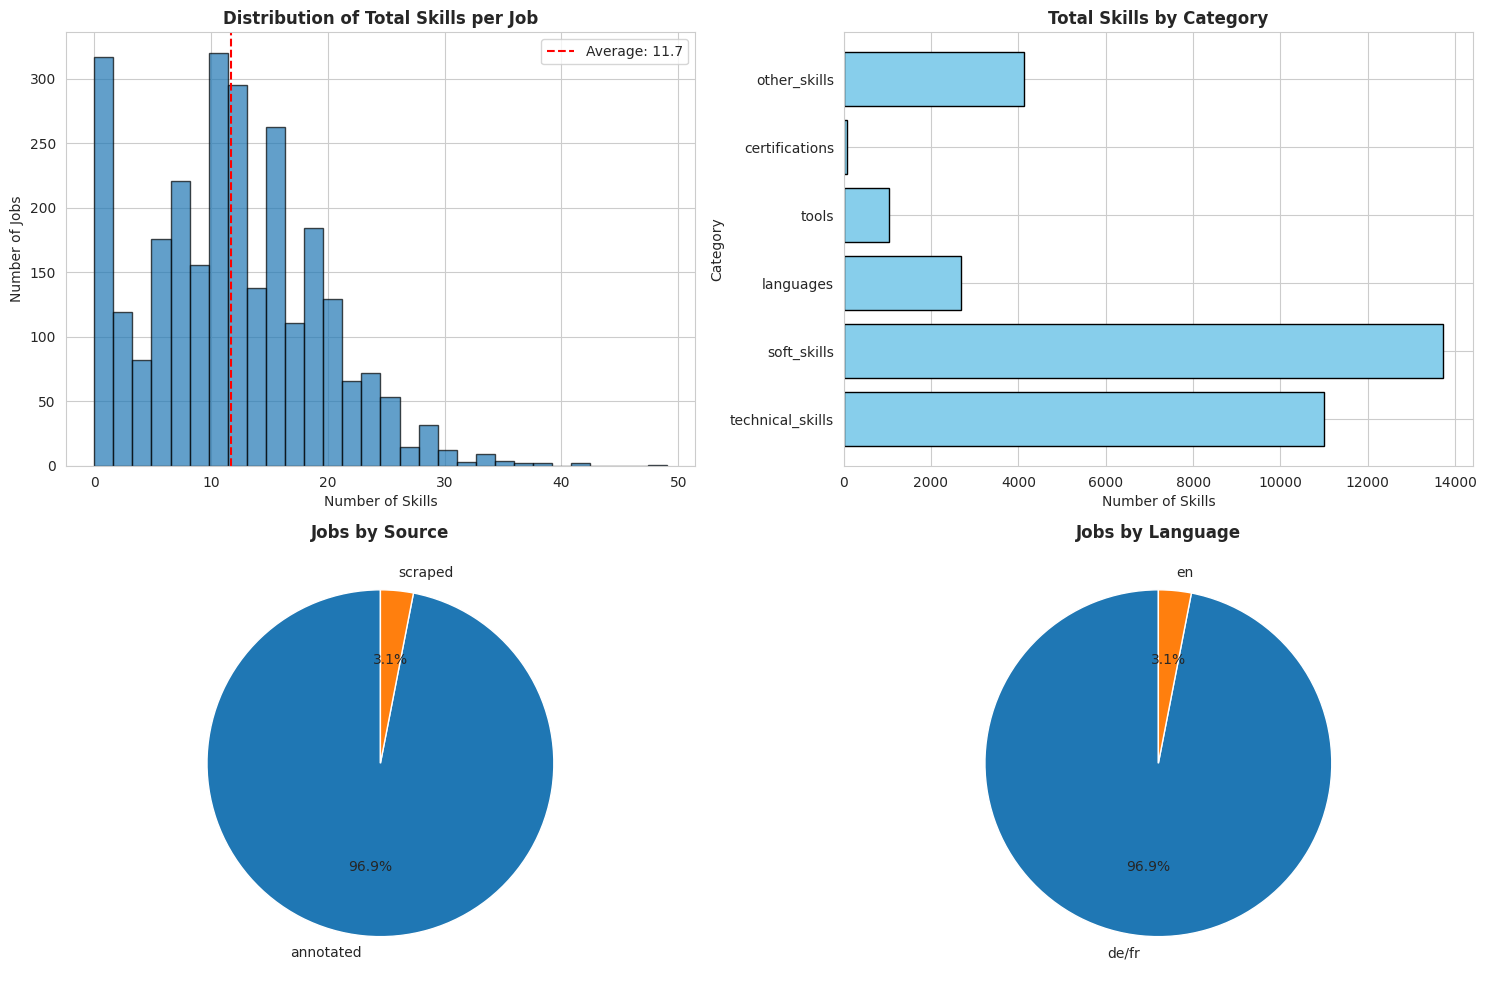


✅ Visualizations created!
   Saved to: /content/llm-skill-extractor/data/skill_extraction_analysis.png


In [18]:
# Create visualizations

# 1. Skills per job distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of total skills per job
skills_counts = [result['total_skills_count'] for result in extraction_results]
axes[0, 0].hist(skills_counts, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Skills per Job', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Skills')
axes[0, 0].set_ylabel('Number of Jobs')
axes[0, 0].axvline(stats['average_skills_per_job'], color='red', linestyle='--', label=f'Average: {stats["average_skills_per_job"]:.1f}')
axes[0, 0].legend()

# Plot 2: Skills by category
categories = list(stats['total_skills_by_category'].keys())
counts = list(stats['total_skills_by_category'].values())
axes[0, 1].barh(categories, counts, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Total Skills by Category', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Skills')
axes[0, 1].set_ylabel('Category')

# Plot 3: Jobs by source
sources = list(stats['jobs_by_source'].keys())
source_counts = list(stats['jobs_by_source'].values())
axes[1, 0].pie(source_counts, labels=sources, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Jobs by Source', fontsize=12, fontweight='bold')

# Plot 4: Jobs by language
languages = list(stats['jobs_by_language'].keys())
lang_counts = list(stats['jobs_by_language'].values())
axes[1, 1].pie(lang_counts, labels=languages, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Jobs by Language', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'skill_extraction_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations created!")
print(f"   Saved to: {os.path.join(DATA_PATH, 'skill_extraction_analysis.png')}")

# 12. Qualitative Evaluation

**Objective:** Manually inspect a sample of extraction results to assess quality.

**Why I need this:**
* **The Issue:** Quantitative metrics don't tell the full story. I need to see if the extracted skills are actually correct and useful.
* **The Fix:** Display sample results for manual inspection.

**What I did:**
Display random samples from the extraction results with full details for quality assessment.

In [19]:
# --- QUALITATIVE EVALUATION ---
# Display sample extraction results for manual quality assessment

import random

print("🔍 QUALITATIVE EVALUATION - Sample Extraction Results")
print("="*80)

# Select 3 random samples
samples = random.sample(extraction_results, min(3, len(extraction_results)))

for i, sample in enumerate(samples, 1):
    print(f"\n{'='*80}")
    print(f"SAMPLE {i}")
    print(f"{'='*80}")
    print(f"Job ID: {sample['job_id']}")
    print(f"Source: {sample['source']}")
    print(f"Language: {sample['language']}")
    if sample.get('title'):
        print(f"Title: {sample['title']}")
    if sample.get('company'):
        print(f"Company: {sample['company']}")
    print(f"Number of skill sections found by BERT: {sample['num_skill_sections']}")
    print(f"Total skills extracted: {sample['total_skills_count']}")

    print(f"\n📋 Extracted Skills:")
    for category, skills in sample['extracted_skills'].items():
        if skills:
            print(f"\n  {category.replace('_', ' ').upper()}:")
            for skill in sorted(skills):
                print(f"    • {skill}")

    if sample['total_skills_count'] == 0:
        print("\n  ⚠️ No skills extracted for this job")

print("\n" + "="*80)
print("\n💡 Quality Assessment Questions:")
print("  1. Are the extracted skills actually mentioned in the job ads?")
print("  2. Are job titles incorrectly classified as skills?")
print("  3. Are skills properly categorized?")
print("  4. Are there obvious skills that were missed?")
print("  5. Are the skill names properly normalized?")

🔍 QUALITATIVE EVALUATION - Sample Extraction Results

SAMPLE 1
Job ID: annotated_2207
Source: annotated
Language: de/fr
Number of skill sections found by BERT: 3
Total skills extracted: 22

📋 Extracted Skills:

  TECHNICAL SKILLS:
    • Electrotechnics
    • Elektrotechnik
    • Medizin-IT Lösungen
    • Network Technology
    • Netzwerktechnik
    • Planung
    • Umsetzung
    • Video Technology
    • Videotechnik

  SOFT SKILLS:
    • Communication Skills
    • Eigenverantwortung
    • Flexibility
    • Kundenorientierung
    • Problem Solving
    • Problemlösungsfähigkeit
    • Self-Organization
    • Teamarbeit
    • Teamwork

  LANGUAGES:
    • English
    • German

  OTHER SKILLS:
    • Willingness to Travel
    • technisch herausfordernd

SAMPLE 2
Job ID: annotated_14
Source: annotated
Language: de/fr
Number of skill sections found by BERT: 3
Total skills extracted: 9

📋 Extracted Skills:

  TECHNICAL SKILLS:
    • Bedienung der Kasse
    • Kaffeezubereitung
    • Mise en place


# 13. Save Results to Google Drive

**Objective:** Backup all extraction results and analyses to Google Drive for permanent storage.

**Why I need this:**
* **The Issue:** Google Colab sessions are temporary - all files will be lost when the session ends.
* **The Fix:** Copy results to Google Drive for permanent storage and access.

**What I did:**
1. Create a backup folder in Google Drive
2. Copy all result files (JSON, images, logs)
3. Verify successful backup

In [20]:
# --- SAVE TO GOOGLE DRIVE ---
# Backup all results to Google Drive

import shutil
import os

# Define Google Drive save path
drive_save_path = '/content/drive/MyDrive/GEN03/skill_extraction_results'

# Create directory if it doesn't exist
os.makedirs(drive_save_path, exist_ok=True)

print(f"💾 Backing up results to Google Drive...")
print(f"   Destination: {drive_save_path}\n")

# List of files to backup
files_to_backup = [
    ('extracted_skills.json', 'Main extraction results'),
    ('skill_statistics.json', 'Summary statistics'),
    ('extraction_errors.json', 'Error log'),
    ('skill_extraction_analysis.png', 'Analysis visualization')
]

# Copy files
backed_up = 0
for filename, description in files_to_backup:
    source_path = os.path.join(DATA_PATH, filename)
    dest_path = os.path.join(drive_save_path, filename)

    if os.path.exists(source_path):
        shutil.copy(source_path, dest_path)
        file_size = os.path.getsize(source_path) / 1024  # Size in KB
        print(f"✅ {filename}")
        print(f"   ({description}, {file_size:.1f} KB)")
        backed_up += 1
    else:
        print(f"⚠️  {filename} not found (skipped)")

print(f"\n🎉 Backup complete!")
print(f"   {backed_up}/{len(files_to_backup)} files backed up successfully")
print(f"   Location: {drive_save_path}")
print("\n✅ You can now safely close this notebook. All data is saved!")

💾 Backing up results to Google Drive...
   Destination: /content/drive/MyDrive/GEN03/skill_extraction_results

✅ extracted_skills.json
   (Main extraction results, 1936.8 KB)
✅ skill_statistics.json
   (Summary statistics, 0.4 KB)
⚠️  extraction_errors.json not found (skipped)
✅ skill_extraction_analysis.png
   (Analysis visualization, 283.8 KB)

🎉 Backup complete!
   3/4 files backed up successfully
   Location: /content/drive/MyDrive/GEN03/skill_extraction_results

✅ You can now safely close this notebook. All data is saved!


In [21]:
# Keep Colab alive
from IPython.display import display, Javascript
display(Javascript('setInterval(function(){console.log("keep alive")}, 60000)'))

<IPython.core.display.Javascript object>

---
# 14. Summary and Next Steps

**🎉 Task 5 Complete!**

### What We Accomplished:
1. ✅ Loaded the fine-tuned BERT model for zone identification
2. ✅ Implemented two-stage extraction pipeline (BERT + LLM)
3. ✅ Processed both annotated and scraped job advertisements
4. ✅ Extracted and categorized professional skills
5. ✅ Generated comprehensive statistics and visualizations
6. ✅ Saved all results to permanent storage

### Key Outputs:
- **extracted_skills.json** - Complete extraction results for all jobs
- **skill_statistics.json** - Summary statistics and metrics
- **skill_extraction_analysis.png** - Visual analysis of results
- **extraction_errors.json** - Log of any errors encountered

### Methodology:
1. **Zone Identification (BERT)**: Used fine-tuned multilingual BERT to identify text sections labeled as "Fähigkeiten und Inhalte" (Skills and Content)
2. **Skill Extraction (LLM)**: Used LLM (OpenAI GPT-4o-mini or Google Gemini 1.5 Flash) with carefully crafted prompts to extract individual skills from identified sections
3. **Categorization**: Organized skills into 6 categories: technical skills, soft skills, languages, tools, certifications, and other skills
4. **Dual LLM Support**: Implemented support for both OpenAI and Gemini APIs, allowing comparison and choice of best model

